<a href="https://colab.research.google.com/github/ramin40/classifying-songs-on-genres-/blob/main/classify_song_genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing necessray libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


importing and reading data

In [ ]:
tracks=pd.read_csv('/content/drive/MyDrive/datasets /fma-rock-vs-hiphop.csv')
enchonest=pd.read_json('/content/drive/MyDrive/datasets /echonest-metrics.json')
echo_tracks=enchonest.merge(tracks[['track_id','genre_top']],on='track_id')
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


incpecting data

In [ ]:
corr_matrix=echo_tracks.corr().abs()
corr_matrix.style.background_gradient()
mask=np.triu(np.ones_like(corr_matrix,dtype=bool))
masked_matrix=corr_matrix.mask(mask)
high_correlated=[ c for c in echo_tracks.columns[:-1]if any(masked_matrix[c]>0.5)]
print(high_correlated)

[]


scaling data and prepering for dimentionary reduction.

In [ ]:
features=echo_tracks.drop(['track_id','genre_top'],axis=1)
labels=echo_tracks['genre_top']
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
scaled_features=ss.fit_transform(features)

implementing PCA

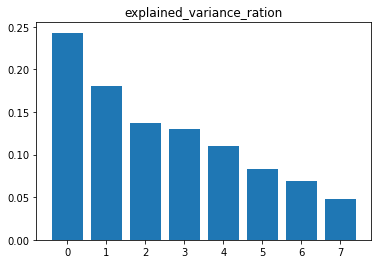

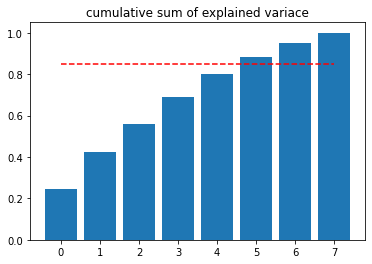

In [ ]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(scaled_features)
varianc=pca.explained_variance_ratio_
n_components=pca.n_components_
plt.bar(range(n_components),varianc)
plt.title('explained_variance_ration')
plt.show()
cum_variance=np.cumsum(varianc)
plt.bar(range(n_components),cum_variance)
plt.hlines(0.85,color='r',linestyles='dashed',xmin=0,xmax=7)
plt.title('cumulative sum of explained variace')
plt.show()
#whiw respect to these plots n_components=6
pca=PCA(n_components=6,random_state=123)
pca_features=pca.fit_transform(scaled_features)

encoding labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
encoded_labels=le.fit_transform(labels).reshape(-1,1)
label_dict=dict({'Rock':0,'Hip-Hop':1})

splitting data and training a decision tree and logestic regression models and compare these together

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
xtrain,xtest,ytrain,ytest=train_test_split(pca_features,encoded_labels,test_size=0.3,random_state=123,
                                           stratify=encoded_labels)
tree=DecisionTreeClassifier()
tree.fit(xtrain,ytrain)
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(xtrain,ytrain)
from sklearn.metrics import classification_report
print(classification_report(ytest,logreg.predict(xtest)))
print(classification_report(ytest,tree.predict(xtest)))

              precision    recall  f1-score   support

           0       0.71      0.54      0.62       273
           1       0.90      0.95      0.92      1168

    accuracy                           0.87      1441
   macro avg       0.81      0.75      0.77      1441
weighted avg       0.86      0.87      0.86      1441

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       273
           1       0.91      0.91      0.91      1168

    accuracy                           0.85      1441
   macro avg       0.76      0.76      0.76      1441
weighted avg       0.85      0.85      0.85      1441



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


unbias classes

In [ ]:
def unbias_class(labels_column,data,label_column_name):
  unbias_class=pd.DataFrame()
  global dict_class
  dict_class={}
  for i,j in enumerate(labels_column.value_counts().index):
    dict_class[j]=labels_column.value_counts()[i]
  if min(dict_class.values())<= 1.5*max(dict_class.values()):
    print('data frame have bias classes')
    print('unbiasing . . .')
    for k,v in dict_class.items():
      if v > 1.3*min(dict_class.values()):
        data.loc[data[label_column_name]==k]= data.loc[data[label_column_name]==k].sample(min(dict_class.values()),random_state=123)
        
  else:
    print('data frame classes are unbias')
  data=data.dropna()
  return data
unbias_data=unbias_class(labels,echo_tracks,'genre_top')

data frame have bias classes
unbiasing . . .


trainig models with biased classes

In [ ]:
features=unbias_data.drop(['track_id','genre_top'],axis=1)
labels=unbias_data['genre_top']
encoded_labels=le.fit_transform(labels)
scaled_features=ss.fit_transform(features)
pca_features=pca.fit_transform(scaled_features)
xtrain,xtest,ytrain,ytest=train_test_split(pca_features,encoded_labels,random_state=12
                                      ,test_size=0.2)
tree=DecisionTreeClassifier()
tree.fit(xtrain,ytrain)
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(xtrain,ytrain)
from sklearn.metrics import classification_report
print(classification_report(ytest,logreg.predict(xtest)))
print(classification_report(ytest,tree.predict(xtest)))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       183
           1       0.82      0.81      0.81       181

    accuracy                           0.82       364
   macro avg       0.82      0.82      0.82       364
weighted avg       0.82      0.82      0.82       364

              precision    recall  f1-score   support

           0       0.80      0.77      0.78       183
           1       0.77      0.80      0.79       181

    accuracy                           0.78       364
   macro avg       0.78      0.78      0.78       364
weighted avg       0.78      0.78      0.78       364



evaluating model

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(tree,xtest,ytest,cv=10,scoring='accuracy').mean()

0.744069069069069